# TSSL Lab 3 - Nonlinear state space models and Sequential Monte Carlo

- Qinyuan QI(qinqi464)

In this lab we will make use of a non-linear state space model for analyzing the dynamics of SARS-CoV-2, the virus causing covid-19. We will use an epidemiological model referred to as a Susceptible-Exposed-Infectious-Recovered (SEIR) model. It is a stochastic adaptation of the model used by the The Public Health Agency of Sweden for predicting the spread of covid-19 in the Stockholm region early in the pandemic, see [Estimates of the peak-day and the number of infected individuals during the covid-19 outbreak in the Stockholm region, Sweden February – April 2020](https://www.folkhalsomyndigheten.se/publicerat-material/publikationsarkiv/e/estimates-of-the-peak-day-and-the-number-of-infected-individuals-during-the-covid-19-outbreak-in-the-stockholm-region-sweden-february--april-2020/).

The background and details of the SEIR model that we will use are available in the document _TSSL Lab 3 Predicting Covid-19 Description of the SEIR model_ on LISAM. Please read through the model description before starting on the lab assignments to get a feeling for what type of model that we will work with.

---

### DISCLAIMER
Even though we will use a type of model that is common in epidemiological studies and analyze real covid-19 data, you should _NOT_ read to much into the results of the lab. The model is intentionally simplified to fit the scope of the lab, it is not validated, and it involves several model parameters that are set somewhat arbitrarily. The lab is intended to be an illustration of how we can work with nonlinear state space models and Sequential Monte Carlo methods to solve a problem of practical interest, but the actual predictions made by the final model should be taken with a big grain of salt.

---


We load a few packages that are useful for solving this lab assignment.

In [457]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)  # Increase default size of plots

## 3.1 A first glance at the data
The data that we will use in this lab is a time series consisting of daily covid-19-related intensive care cases in Stockholm from March 2020 to March 2021. As always, we start by loading and plotting the data.

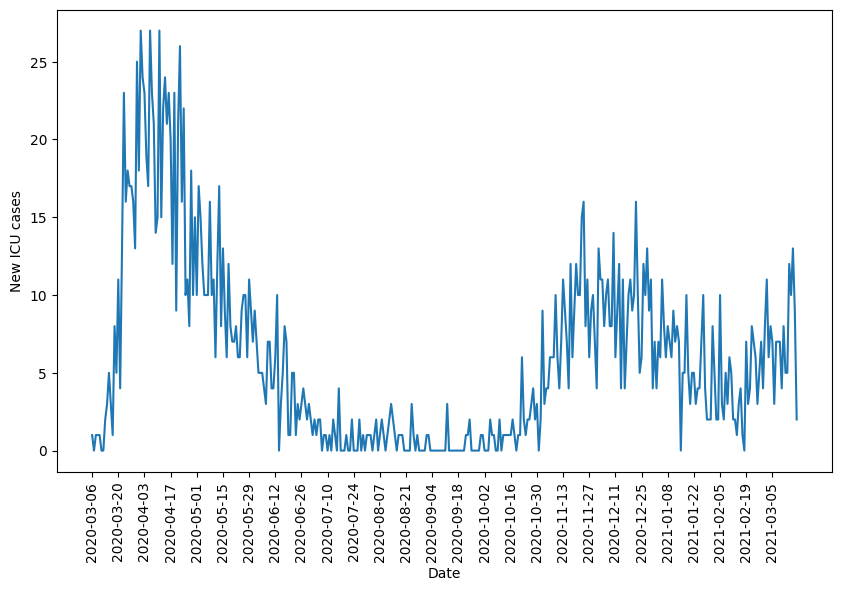

In [458]:
data = pandas.read_csv('SIR_Stockholm.csv',header=0)
y_sthlm = data['ICU'].values
u_sthlm = data['Date'].values
ndata = len(y_sthlm)
plt.plot(u_sthlm,y_sthlm)
plt.xticks(range(0, ndata, 14), u_sthlm[::14], rotation = 90)  # Show only one tick per 2 week for clarity
plt.xlabel('Date')
plt.ylabel('New ICU cases')
plt.show()

**Q0:** What type of values can the observations $y_t$ take? Is a Gaussian likelihood model a good choice if we want to respect the properties of the data?

**A0:**

From the plot above, we found that the values of the observations $y_t$ are non-negative integers, range around [0,27]. 

We also notice that the data has a repeating pattern over time, where the range of New ICU cases (variance) get smaller after one season.

Gaussian likelihood model can be used on a non-negative data when data has constant variance,
However, in our case, the variance of the data is not constant, so the Gaussian likelihood model is not a good choice.

## 3.2 Setting up and simulating the SEIR model
In this section we will set up a SEIR model and use this to simulate a synthetic data set. You should keep these simulated trajectories, we will use them in the following sections.

In [459]:
from tssltools_lab3 import Param, SEIR

"""For Stockholm the population is probably roughly 2.5 million."""
population_size = 2500000  

"""" Binomial probabilities (p_se, p_ei, p_ir, and p_ic) and the transmission rate (rho)"""
pse = 0        # This controls the rate of spontaneous s->e transitions. It is set to zero for this lab.
pei = 1 / 5.1  # Based on FHM report - 5.1 is a empirical constant
pir = 1 / 5    # Based on FHM report - 5 is a empirical constant 

pic = 1 / 1000 # Quite arbitrary! # probability that an infectious individual enters ICU
rho = 0.3      # Quite arbitrary!

""" The instantaneous contact rate b[t] is modeled as
  b[t] = exp(z[t])   # b is a main factor, z is a parameter used here.
  z[t] = z[t-1] + epsilon[t], epsilon[t] ~ N(0,sigma_epsilon^2)
"""
sigma_epsilon = .1

""" For setting the initial state of the simulation"""
i0 = 1000  # Mean number of infectious individuals at initial time point
e0 = 5000  # Mean number of exposed...
r0 = 0     # Mean number of recovered
s0 = population_size - i0 - e0 - r0  # Mean number of susceptible
init_mean = np.array([s0, e0, i0, 0.], dtype=np.float64)  # The last 0. is the mean of z[0]

"""All the above parameters are stored in params."""
params = Param(pse, pei, pir, pic, rho, sigma_epsilon, init_mean, population_size)

""" Create a model instance"""
model = SEIR(params)

**Q1:** Generate $10$ different trajectories of length $200$ from the model an plot them in one figure. Does the trajectories look reasonable? Could the data have been generated using this model? 

For reproducability, we set the seed of the random number generator to 0 before simulating the trajectories using np.random.seed(0)

Save these $10$ generated trajectories for future use.

*(hint: The SEIR class has a simulate method)*

**A1:**

In [460]:
np.random.seed(0)
help(model.simulate)

Help on method simulate in module tssltools_lab3:

simulate(T, N=1) method of tssltools_lab3.SEIR instance
    Simulates the SEIR model for a given number of time steps. Multiple trajectories
    can be simulated simulataneously.
    
    Parameters
    ----------
    T : int
        Number of time steps to simulate the model for.
    N : int, optional
        Number of independent trajectories to simulate. The default is 1.
    
    Returns
    -------
    alpha : ndarray
        Array of size (d,N,T) with state trajectories. alpha[:,i,:] is the i:th trajectory.
    y : ndarray
        Array of size (1,N,T) with observations.



In [461]:
# alpha: state trajectories(alpha[0]:s, alpha[1]:e, alpha[2]:i)
# y:number of ICU cases
alpha, y = model.simulate(T=200, N=10)

# get recovery number
rec_num = population_size - np.sum(alpha[:3,:,:],axis=0)

In [462]:
print(np.shape(alpha))
print(np.shape(y))

(4, 10, 200)
(1, 10, 200)


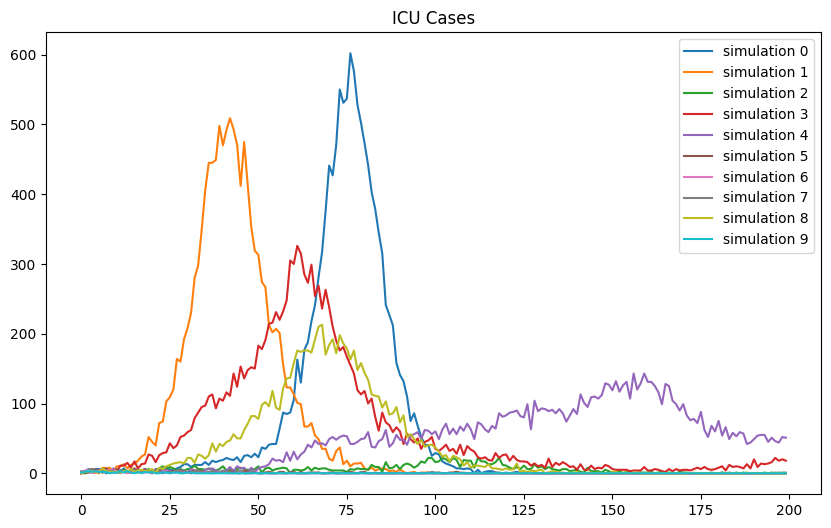

In [463]:
for i in range(10):
    plt.plot(y[0,i,:],label="simulation " + str(i))
plt.title("ICU Cases")
plt.legend()

In [464]:
# get the y_sthlm(ICU) range
icu_min = np.min(y_sthlm)
icu_max = np.max(y_sthlm)
# print
print("ICU cases range on the given data: [", icu_min,",", icu_max,"]")


ICU cases range on the given data: [ 0 , 27 ]


We can also plot the Susceptible, Exposed, Infectious, and Recovered populations over time. as follows:

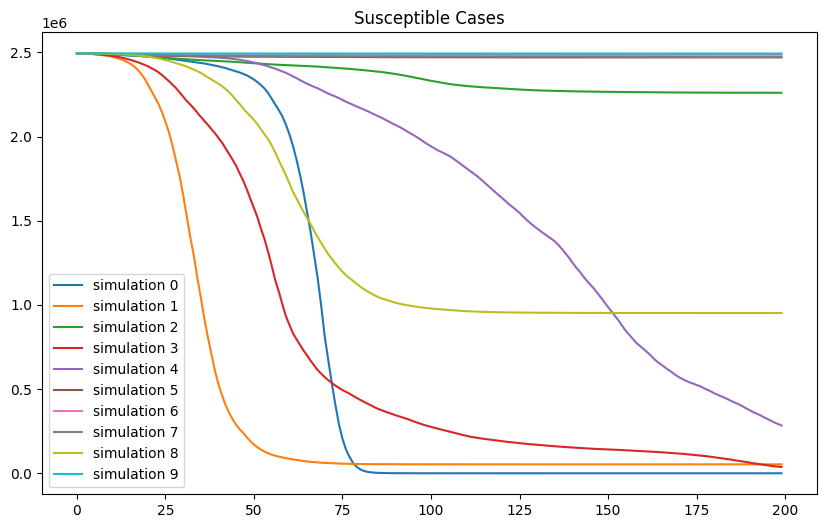

In [465]:
for i in range(10):
    plt.plot(alpha[0,i,:],label="simulation " + str(i))
plt.title("Susceptible Cases") 
plt.legend()

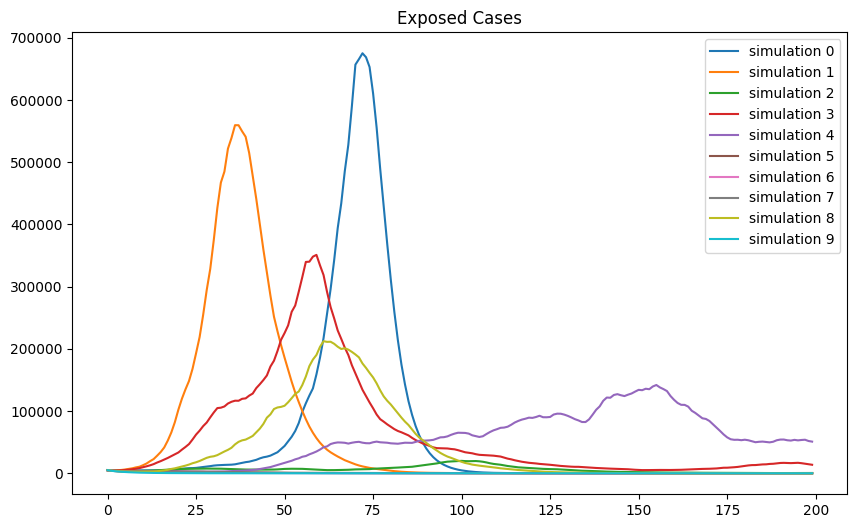

In [466]:
for i in range(10):
    plt.plot(alpha[1,i,:],label="simulation " + str(i))
plt.title("Exposed Cases") 
plt.legend()

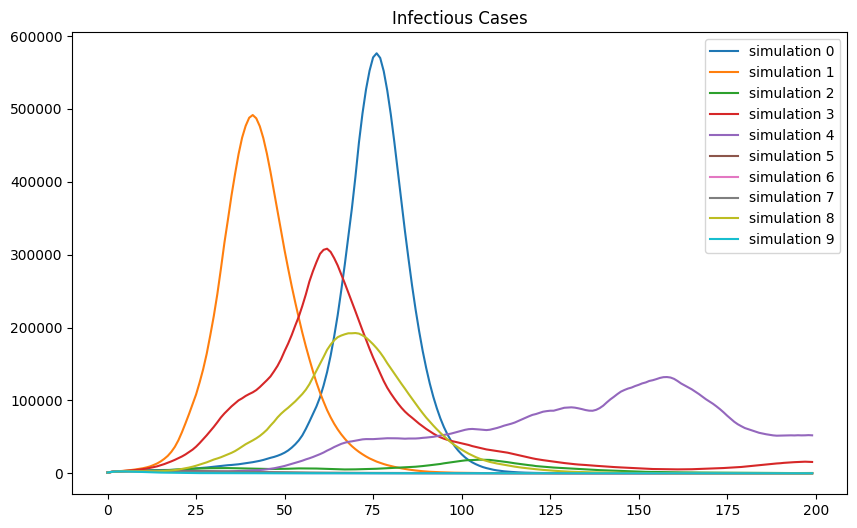

In [467]:
for i in range(10):
    plt.plot(alpha[2,i,:],label="simulation " + str(i))
plt.title("Infectious Cases")
plt.legend()

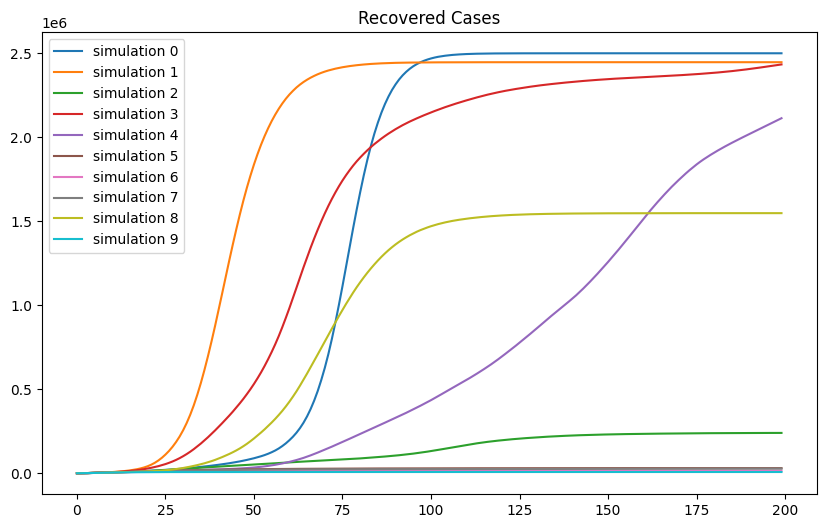

In [468]:
for i in range(10):
    plt.plot(rec_num[i],label="simulation " + str(i))
plt.title("Recovered Cases")
plt.legend()

The shape of those trajectories looks reasonable, but we also found that the generated ICU data get to as high as 500 or 600, but in the given data, the ICU number is in the range of [0,27], so the trajectories seems not so reasonable, which means the data could not have been generated using this model.

## 3.3 Sequential Importance Sampling

Next, we pick out one trajectory that we will use for filtering. We use simulated data to start with, since we then know the true underlying SEIR states and can compare the filter results with the ground truth.

**Q2:** Implement the **Sequential Importance Sampling** algorithm by filling in the following functions.

The **exp_norm** function should return the normalized weights and the log average of the unnormalized weights.
For numerical reasons, when calculating the weights we should "normalize" the log-weights first by removing the maximal value.

Let $\bar{\omega}_t = \max(\log \omega_t^i)$ and take the exponential of $\log \tilde{\omega}_t^i = \log \omega_t^i - \bar{\omega}_t$. Normalizing $\tilde{\omega}_t^i$ will yield the normalized weights!

For the log average of the unnormalized weights, care has to be taken to get the correct output,
$\log (1/N \sum_{i=1}^{N} \tilde{\omega}_t^i) = \log( 1/N \sum_{i=1}^{N} \omega_t^i) - \bar{\omega}_t$.
We are going to need this in the future, so best to implement it right away.

*(hint: look at the SEIR model class, it contains all necessary functions for propagation and weighting)*

In [469]:
from tssltools_lab3 import smc_res

def exp_norm(logwgt):
    """
    Exponentiates and normalizes the log-weights.
    
    Parameters
    ----------
    logwgt : ndarray
        Array of size (N,) with log-weights.
    
    Returns
    -------
    wgt : ndarray
        Array of size (N,) with normalized weights, wgt[i] = exp(logwgt[i])/sum(exp(logwgt)),
        but computed in a /numerically robust way/!
    logZ : float
        log of the normalizing constant, logZ = log(sum(exp(logwgt))),
        but computed in a /numerically robust way/!
    """        
    N = len(logwgt)
    wgt_bar = max(logwgt)

    logwgt_tilde = logwgt - wgt_bar

    # get wgt_tilde
    wgt_tilde = np.exp(logwgt_tilde)
    # get sum of wgt_tilde
    sum_wgt_tilde = np.sum(wgt_tilde)

    # normliaze the wgt_tilde
    wgt = wgt_tilde / sum_wgt_tilde

    # get logZ
    # this version is according to the formula in the question
    #logZ = np.log(sum_wgt_tilde / N) + wgt_bar
    # this version is according to the comment in the function definition
    logZ = np.log(sum_wgt_tilde) + wgt_bar

    return wgt, logZ

def ESS(wgt):
    """
    Computes the effective sample size.
    
    Parameters
    ----------
    wgt : ndarray
        Array of size (N,) with normalized importance weights.
    
    Returns
    -------
    ess : float
        Effective sample size.
    """       

    ess = (np.sum(wgt)**2) / np.sum(wgt**2) 
    
    return ess

def sis_filter(model, y, N):
    d = model.d
    n = len(y)
    
    # Allocate memory
    particles = np.zeros((d, N, n), dtype = float)  # All generated particles
    logW = np.zeros((1, N, n))  # Unnormalized log-weight
    W = np.zeros((1, N, n))  # Normalized weight
    alpha_filt = np.zeros((d, 1, n))  # Store filter mean
    N_eff = np.zeros(n)  # Efficient number of particles
    logZ = 0.  # Log-likelihood estimate

    # Filter loop
    for t in range(n):
        # Sample from "bootstrap proposal"
        if t == 0:            
            particles[:, :, 0] = model.sample_state(alpha0=None, N=N) # Initialize from p(alpha_1)
            logW[0, :, 0] = model.log_lik(y = y[0], alpha = particles[:, :, 0]) # Compute weights
        else:
            # Propagate according to dynamics
            particles[:, :, t] =  model.sample_state(alpha0=particles[:, :, t-1], N=N) 
            # Update weights
            logW[0, :, t] = logW[0, :, t-1] + \
                model.log_lik(y = y[t], alpha = particles[:, :, t]) 

        # Normalize the importance weights and compute N_eff
        W[0, :, t], _ = exp_norm(logW[0, :, t])
        N_eff[t] = ESS(W[0,:,t])

        # Compute filter estimates
        alpha_filt[:, 0, t] = np.sum(particles[:, :, t] * W[0, :, t], axis=1) 
        
    return smc_res(alpha_filt, particles, W, logW=logW, N_eff=N_eff)

**Q3:** Choose one of the simulated trajectories and run the SIS algorithm using $N = 100$ particles. Show plots comparing the filter means from the SIS algorithm with the underlying truth of the Infected, Exposed and Recovered. 

Also show a plot of how the ESS behaves over the run. 

*(hint: In the model we use the S, E, I as states, but S will be much larger than the others. To calculate R, note that S + E + I + R = Population)*

**A3:**

First We plot the trajectory 2 of the simulated data, as follows:

Text(0.5, 1.0, 'ICU Cases when trajectory = 2')

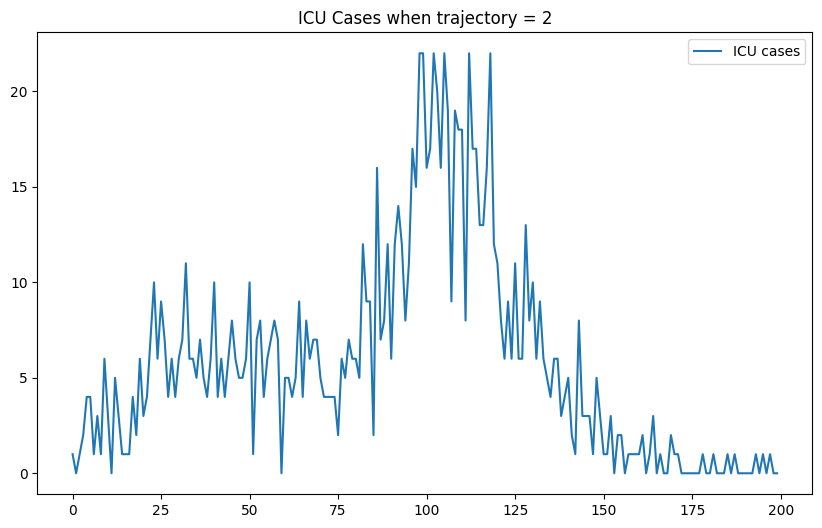

In [470]:
# select trajectory to test the function
selected_trajectory = 2

plt.plot(y[0,selected_trajectory,:], label = 'ICU cases')
#plt.plot(alpha[0,selected_trajectory,:], label = 'Susceptible')
#plt.plot(alpha[1,selected_trajectory,:], label = 'Exposed')
#plt.plot(alpha[2,selected_trajectory,:], label = 'Infected')
#plt.plot(rec_num[selected_trajectory], label = 'Recovered')
plt.legend()
plt.title("ICU Cases when trajectory = " + str(selected_trajectory))

Then we plot the filter means from the SIS algorithm along with the underlying truth of the Infected, Exposed and Recovered, as follows:

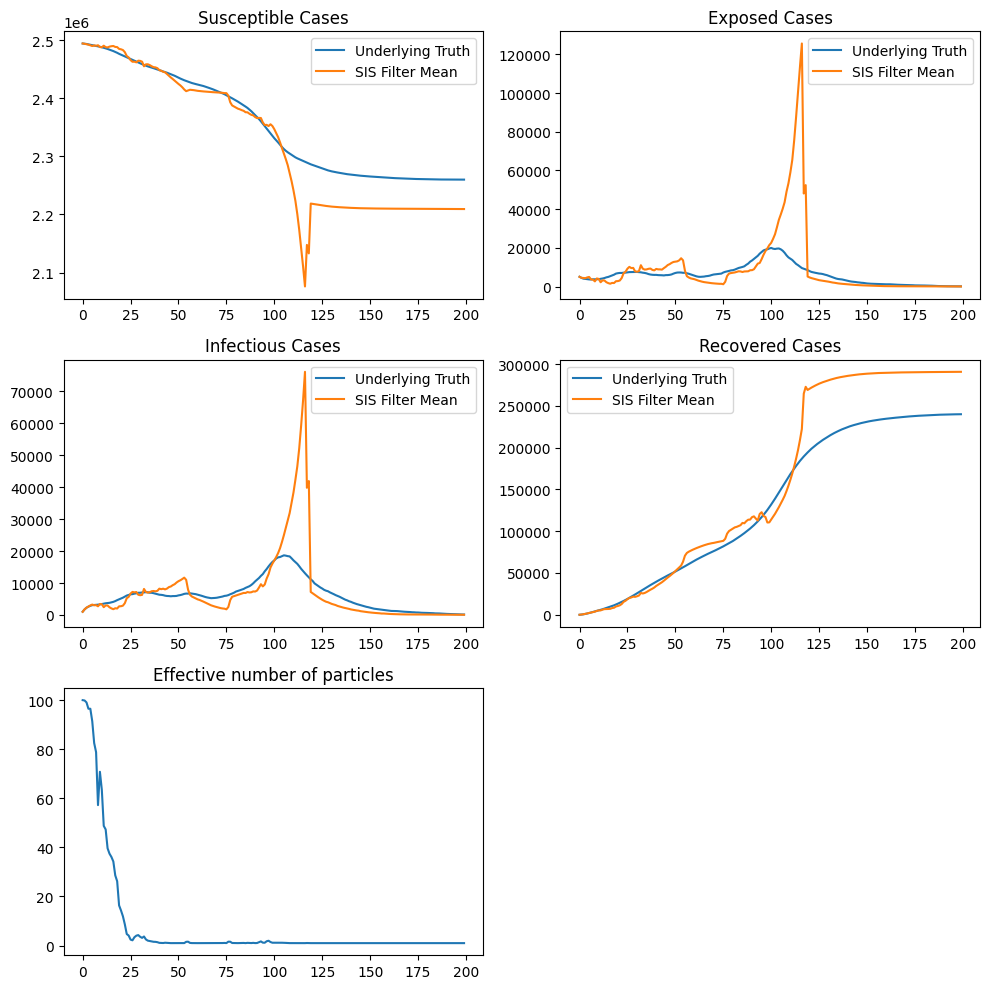

In [471]:
sis = sis_filter(model = model, y = y[0, selected_trajectory, :], N = 100)

# recovery case
rec_num_real = population_size - np.sum(alpha[:3,selected_trajectory,:],axis=0)
rec_num_sis = population_size - np.sum(sis.alpha_filt[:3,0,:], axis=0)

# plot
plt.rcParams["figure.figsize"] = (10,10)  # Increase default size of plots

fig, ax = plt.subplots(3,2)

ax[0,0].plot(alpha[0,selected_trajectory,:], label = 'Underlying Truth')
ax[0,0].plot(sis.alpha_filt[0,0,:], label = 'SIS Filter Mean')
ax[0,0].set(title = "Susceptible Cases")
ax[0,0].legend()

ax[0,1].plot(alpha[1,selected_trajectory,:], label = 'Underlying Truth')
ax[0,1].plot(sis.alpha_filt[1,0,:], label = 'SIS Filter Mean')
ax[0,1].set(title = "Exposed Cases")
ax[0,1].legend()

ax[1,0].plot(alpha[2,selected_trajectory,:], label = 'Underlying Truth')
ax[1,0].plot(sis.alpha_filt[2,0,:], label = 'SIS Filter Mean')
ax[1,0].set(title = "Infectious Cases")
ax[1,0].legend()

ax[1,1].plot(rec_num_real, label = 'Underlying Truth')
ax[1,1].plot(rec_num_sis, label = 'SIS Filter Mean')
ax[1,1].set(title = "Recovered Cases")
ax[1,1].legend()

# effective number of particles
ax[2,0].plot(sis.N_eff)
ax[2,0].set(title = "Effective number of particles")

# Hide the unused 6th subplot (bottom right)
fig.delaxes(ax[2, 1])

# Adjust layout to avoid overlap
plt.tight_layout()

# reset default size of plots
plt.rcParams["figure.figsize"] = (10,6) 


We found that the filter means of the Infected, Exposed, and Recovered are not very 
stable and not close to the underlying truth in some time steps, and this make SIS mean not 
good estimator for the underlying truth.

The reason behind this is that in the SIS algorithm, the weights of the particles 
will depend on the particles,and the weights will be updated several times, but 
we also found that the effective number of particles will become very close to 1
after some time steps, and weights of the particles will be updated using 
only one particle, which is not good for the estimation.

## 3.4 Sequential Importance Sampling with Resampling

Pick the same simulated trajectory as for the previous section.

**Q4:** Implement the **Sequential Importance Sampling with Resampling** or **Bootstrap Particle Filter** by completing the code below.

In [472]:
def bpf(model, y, numParticles):
    d = model.d
    n = len(y)
    N = numParticles
    
    # Allocate memory
    particles = np.zeros((d, N, n), dtype = float)  # All generated particles
    logW = np.zeros((1, N, n))  # Unnormalized log-weight
    W = np.zeros((1, N, n))  # Normalized weight
    alpha_filt = np.zeros((d, 1, n))  # Store filter mean
    N_eff = np.zeros(n)  # Efficient number of particles
    logZ = 0.  # Log-likelihood estimate

    # Filter loop
    for t in range(n):
        # Sample from "bootstrap proposal"
        if t == 0:  # Initialize from prior
            particles[:, :, 0] = model.sample_state(alpha0=None, N=N) 
        else:  # Resample and propagate according to dynamics
            ind = np.random.choice(N, N, replace=True, p=W[0, :, t-1])
            resampled_particles = particles[:, ind, t-1] 
            particles[:, :, t] = model.sample_state(alpha0=resampled_particles, N=N) 

        # Compute weights
        logW[0, :, t] = model.log_lik(y = y[t], alpha = particles[:, :, t]) 
        W[0, :, t], logZ_now = exp_norm(logW[0, :, t])
        logZ +=  logZ_now - np.log(N) # Update log-likelihood estimate
        N_eff[t] = ESS(W[0,:,t]) 

        # Compute filter estimates
        alpha_filt[:, 0, t] = np.sum(particles[:, :, t] * W[0, :, t], axis=1)  
        
    return smc_res(alpha_filt, particles, W, N_eff = N_eff, logZ = logZ)

**Q5:** Use the same simulated trajectory as above and run the BPF algorithm using $N = 100$ particles. Show plots comparing the filter means from the Bootstrap Particle Filter algorithm with the underlying truth of the Infected, Exposed and Recovered. Also show a plot of how the ESS behaves over the run. Compare this with the results from the SIS algorithm.

**A5:**

The code implementation of the BPF algorithm is as follows.

Comparing the result from SIS algorithm with the BPF algorithm, we found that the filter means of the Infected, Exposed, and Recovered are more stable and closer to the underlying truth.

This is because bootstrap particle filter will resample the particles each time step, which means the ffective number of particles will keep at a high level in most of the time, this make the weights of the particles will be updated using most of the particles all the time and make the filter means more stable and closer to the underlying truth.

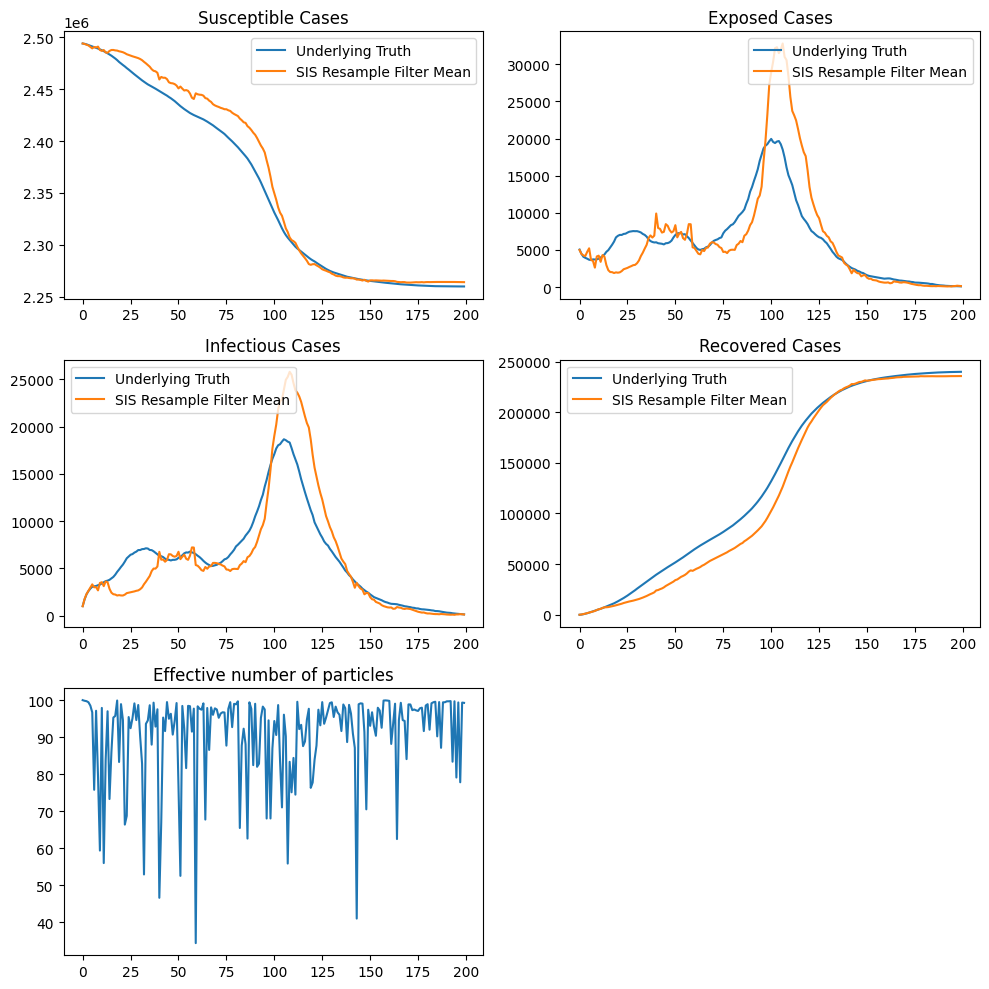

In [473]:
sis_resample = bpf(model = model, y = y[0, selected_trajectory, :], numParticles = 100)

# recovery case
rec_num_real = population_size - np.sum(alpha[:3,selected_trajectory,:],axis=0)
rec_num_sis_resample = population_size - np.sum(sis_resample.alpha_filt[:3,0,:], axis=0)

# plot
plt.rcParams["figure.figsize"] = (10,10)  # Increase default size of plots

fig, ax = plt.subplots(3,2)

ax[0,0].plot(alpha[0,selected_trajectory,:], label = 'Underlying Truth')
ax[0,0].plot(sis_resample.alpha_filt[0,0,:], label = 'SIS Resample Filter Mean')
ax[0,0].set(title = "Susceptible Cases")
ax[0,0].legend()

ax[0,1].plot(alpha[1,selected_trajectory,:], label = 'Underlying Truth')
ax[0,1].plot(sis_resample.alpha_filt[1,0,:], label = 'SIS Resample Filter Mean')
ax[0,1].set(title = "Exposed Cases")
ax[0,1].legend()

ax[1,0].plot(alpha[2,selected_trajectory,:], label = 'Underlying Truth')
ax[1,0].plot(sis_resample.alpha_filt[2,0,:], label = 'SIS Resample Filter Mean')
ax[1,0].set(title = "Infectious Cases")
ax[1,0].legend()

ax[1,1].plot(rec_num_real, label = 'Underlying Truth')
ax[1,1].plot(rec_num_sis_resample, label = 'SIS Resample Filter Mean')
ax[1,1].set(title = "Recovered Cases")
ax[1,1].legend()

# effective number of particles
ax[2,0].plot(sis_resample.N_eff)
ax[2,0].set(title = "Effective number of particles")

# Hide the unused 6th subplot (bottom right)
fig.delaxes(ax[2, 1])

# Adjust layout to avoid overlap
plt.tight_layout()

# reset default size of plots
plt.rcParams["figure.figsize"] = (10,6) 

## 3.5 Estimating the data likelihood and learning a model parameter
In this section we consider the real data and learning the model using this data. For simplicity we will only look at the problem of estimating the $\rho$ parameter and assume that others are fixed.

You are more than welcome to also study the other parameters.

Before we begin to tweak the parameters we run  the particle filter using the current parameter values to get a benchmark on the log-likelihood.

**Q6:** Run the bootstrap particle filter using $N=200$ particles on the real dataset and calculate the log-likelihood. Rerun the algorithm 20 times and show a box-plot of the log-likelihood.

**A6:**

Using the box plot below, we can use several metrics to estimate the log-likelihood of the data generated by SIS. 
Metrics such as the median, the quartile and min/max can be used.
Outside of Whiskers(the box), we can also find a outlier, which is around -1050

The varying log-likelihoods are due to the randomness of the particles which is generated by bootstrap particle filter in 
the bpf algorithm.

Text(0.5, 1.0, 'Loglikelihood using boxplot')

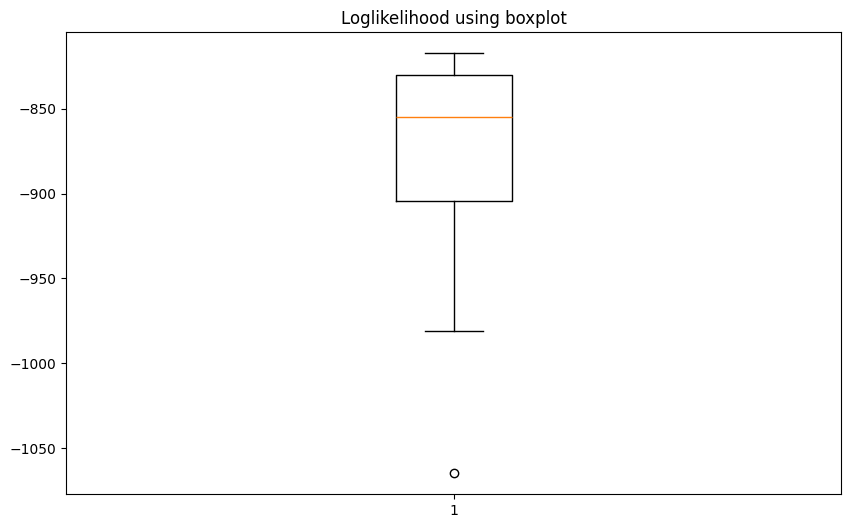

In [474]:
# init loglikelihood vector(20 times)
loglik_q6 = np.zeros(20)

# run the bpf 20 times
for i in range(20):
    sis_resample = bpf(model = model, y = y_sthlm, numParticles = 200)
    loglik_q6[i] = sis_resample.logZ

# plot the loglikelihood using boxplot
plt.boxplot(loglik_q6)
plt.title("Loglikelihood using boxplot")

In [475]:
loglik_q6

array([ -830.57091018,  -849.0187443 ,  -915.54931094,  -873.33142576,
        -830.04717129,  -935.08223009, -1064.87585928,  -900.65591193,
        -828.86396286,  -860.66957017,  -817.23349508,  -922.94570139,
        -821.83374865,  -861.11211067,  -869.86807792,  -980.94512859,
        -827.45360275,  -826.02235413,  -846.31915782,  -831.77985051])

**Q7:** Make a grid of the $\rho$ parameter in the interval $[0.1, 0.9]$. Use the bootstrap particle filter to calculate the log-likelihood for each value. Run the bootstrap particle filter using $N=200$ multiple times (at least 20) per value and use the average as your estimate of the log-likelihood. Plot the log-likelihood function and mark the maximal value.

*(hint: use np.linspace to create a grid of parameter values)*

In [476]:
# deine the number of particles
particle_num = 200

# run 30 times
num_runs = 30

# make a grid of rho prarameter in the range of 0.1 to 0.9
rho_grid = np.linspace(0.1, 0.9, 100)

# allocate memory for the log-likelihood, run 50 times
loglik_q7 = np.zeros((len(rho_grid),num_runs))

for i in range(len(rho_grid)):

    model.set_param(rho = rho_grid[i])
    
    # set the rho parameter
    params.rho = rho_grid[i]
    for j in range(num_runs):
        sis_resample = bpf(model = model, y = y_sthlm, numParticles = particle_num)
        loglik_q7[i,j] = sis_resample.logZ
        
        

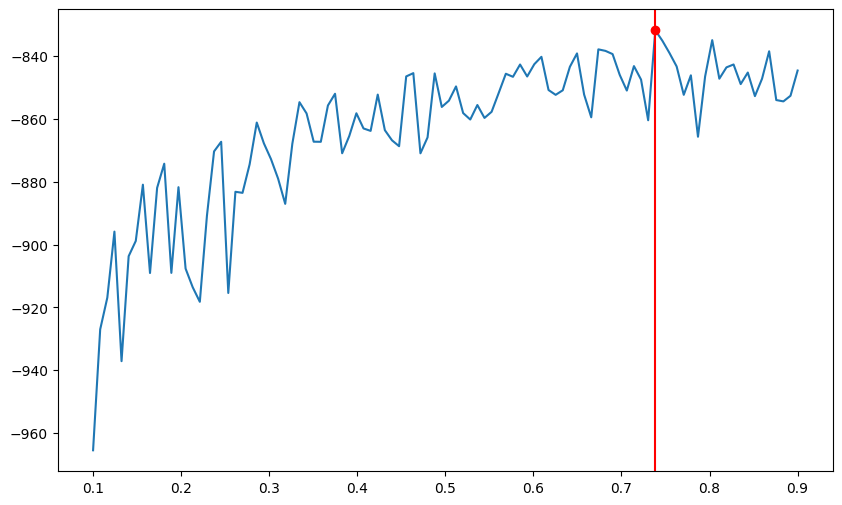

In [477]:
# use avg as estimate value
loglik_q7_est = np.mean(loglik_q7, axis = 1)

# plot
plt.plot(rho_grid, loglik_q7_est)
# draw max value line
plt.axvline(x = rho_grid[loglik_q7_est == np.max(loglik_q7_est)], color = 'red')
# draw max value point
plt.plot(rho_grid[loglik_q7_est == np.max(loglik_q7_est)], np.max(loglik_q7_est), 
         marker = 'o', color = 'red')

In [478]:
# get the max rpo value
rho_max = rho_grid[loglik_q7_est == np.max(loglik_q7_est)]

# print
print("The max likelihood happened at rho value ", rho_max)

The max likelihood happened at rho value  [0.73838384]


We can say there is approximately 73.8% risk of exposure to the COVID-19 virus in the Stockholm region when you are near an infected person.

**Q8:** Run the bootstrap particle filter on the full dataset with the optimal $\rho$ value. Present a plot of the estimated Infected, Exposed and Recovered states.

**A8:**

Compared with the original ICU data of Stockholm, we found that the pattern of the estimated Exposed, Infected data are similar to the original ICU data, which contains
two big waves at the beginning and middle to late part of the timeline.

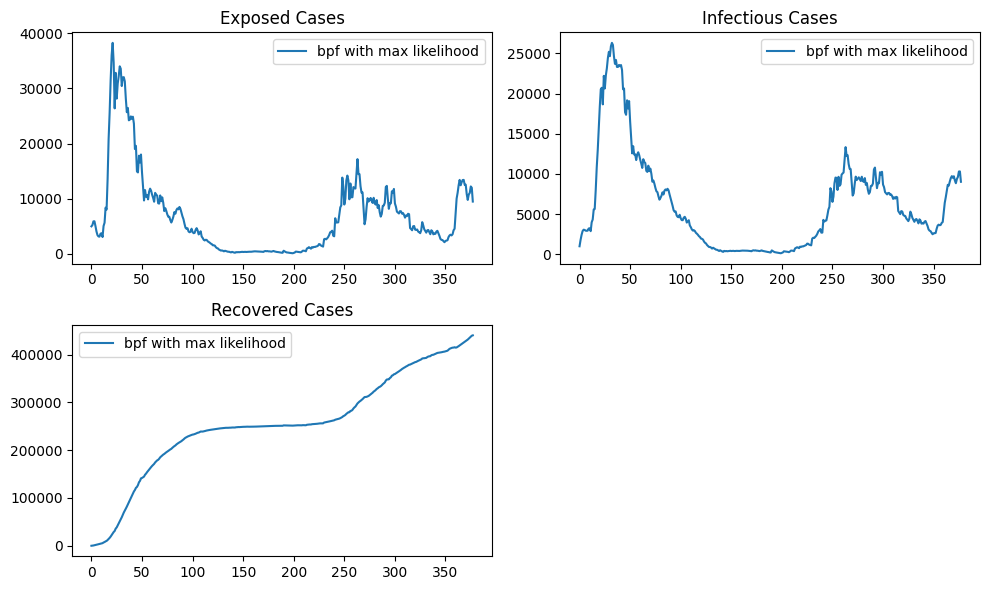

In [479]:
# run the bpf with the max rho value
model.set_param(rho = rho_max)

sis_resample_final = bpf(model = model, y = y_sthlm, numParticles = particle_num)

rec_num_sis_resample_final = population_size - np.sum(sis_resample_final.alpha_filt[:3,0,:], axis=0)

# plot
fig, ax = plt.subplots(2,2)


ax[0,0].plot(sis_resample_final.alpha_filt[1,0,:], label = 'bpf with max likelihood')
ax[0,0].set(title = "Exposed Cases")
ax[0,0].legend()


ax[0,1].plot(sis_resample_final.alpha_filt[2,0,:], label = 'bpf with max likelihood')
ax[0,1].set(title = "Infectious Cases")
ax[0,1].legend()

ax[1,0].plot(rec_num_sis_resample_final, label = 'bpf with max likelihood')
ax[1,0].set(title = "Recovered Cases")
ax[1,0].legend()

# Hide the unused 4th subplot (bottom right)
fig.delaxes(ax[1, 1])

# Adjust layout to avoid overlap
plt.tight_layout()